In [11]:
import torch.nn as nn

class Heu(nn.Module):
    def __init__(self, input_size: int, output_size: int, layer_sizes: list[int], dropout: float=0.1):
        super(Heu, self).__init__()
        layers = []
        # flat = nn.Flatten(start_dim=1)
        # layers.append(flat)
        old_size = input_size
        for layer in layer_sizes:
            layers.append(nn.Linear(old_size, layer))
            layers.append(nn.BatchNorm1d(layer))
            layers.append(nn.Sigmoid())
            layers.append(nn.Dropout(dropout))
            old_size = layer

        layers.append(nn.Linear(old_size, output_size))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)




## Piece adventage in training

In [2]:
import torch
import chess

def create_tensor(board: chess.Board, transform: bool=False):
    matrix_board = torch.zeros((6, 8, 8))
    for i in range(8):
        for j in range(8):
            piece = board.piece_at(chess.square(i, j))
            if piece is not None:
                piece_type = piece.piece_type
                piece_color = piece.color
                index = piece_type - 1

                row = 7-j if not transform else j

                if piece_color == chess.WHITE:
                    matrix_board[index, row, i] = 1
                else:
                    matrix_board[index, row, i] = -1
    if transform:
        matrix_board *= -1
        matrix_board = torch.where(torch.abs(matrix_board) < 1e-6, torch.zeros_like(matrix_board), matrix_board)
    
    return matrix_board.view(6*8*8)



In [44]:
base_fens = [
    "4k3/3ppp2/8/8/8/8/3PPP2/4K3 b KQkq - 0 1",
    "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1",
    "2b1kb2/3ppp2/8/8/8/8/3PPP2/2B1KB2 b KQkq - 0 1",
    "2n1kn2/3ppp2/8/8/8/8/3PPP2/2N1KN2 b KQkq - 0 1",
    "2r1kr2/3ppp2/8/8/8/8/3PPP2/2R1KR2 b KQkq - 0 1",
    "3qk3/3ppp2/8/8/8/8/3PPP2/3QK3 b KQkq - 0 1",
    "3k4/2ppp3/8/8/8/8/2PPP3/3K4 w KQkq - 0 1",
    "3k3r/2p1p3/3p4/8/8/3P4/2P1P3/3K3R w KQkq - 0 1"
]

def get_boards(piece_to_set):
    boards = []
    squares = chess.SQUARES

    for base_fen in base_fens:
        board = chess.Board(base_fen)
        
        for square in squares:
            piece = board.piece_at(square)
            if piece is None:
                temp_board = board.copy()
                temp_board.set_piece_at(square, piece_to_set)
                boards.append(temp_board)
    return boards



In [46]:
for base_fen in base_fens:
    board = chess.Board(base_fen)
    print(board)
    print("-" * 16)

. . . . k . . .
. . . p p p . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . P P P . .
. . . . K . . .
----------------
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
----------------
. . b . k b . .
. . . p p p . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . P P P . .
. . B . K B . .
----------------
. . n . k n . .
. . . p p p . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . P P P . .
. . N . K N . .
----------------
. . r . k r . .
. . . p p p . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . P P P . .
. . R . K R . .
----------------
. . . q k . . .
. . . p p p . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . P P P . .
. . . Q K . . .
----------------
. . . k . . . .
. . p p p . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . P P P . . .
. . . K . . . .
--

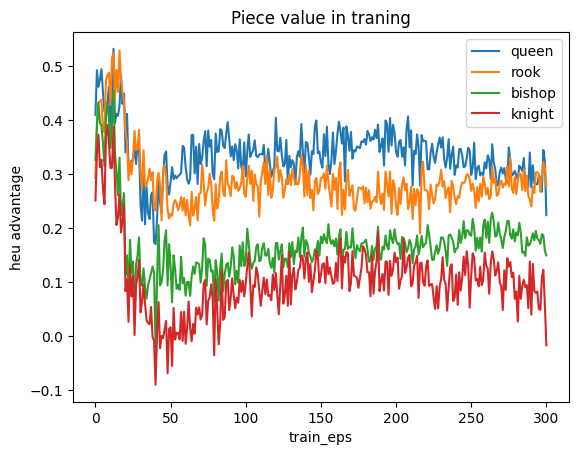

In [42]:
import matplotlib.pyplot as plt

pieces_to_check = [
    chess.QUEEN,
    chess.ROOK,
    chess.BISHOP,
    chess.KNIGHT
]

last_weight = 300
epochs = [i for i in range(last_weight+1)]
model = Heu(6*8*8 + 1, 1, [384 + 1, 500, 800, 1000, 1000, 1000, 1000, 800, 600, 400, 200, 100, 64], 0).to("cuda")
model.eval()
weights_path = "../models/heus/"

plt.title("Piece value in traning")
plt.ylabel("heu advantage")
plt.xlabel("train_eps")
for piece_type in pieces_to_check:

    scores = []

    for num in range(last_weight+1):

        weights = weights_path + f"model_weights_{num}.pth"
        model.load_state_dict(torch.load(weights, weights_only=True))
    
        white_boards = get_boards(chess.Piece(piece_type, chess.WHITE))
        black_boards = get_boards(chess.Piece(piece_type, chess.BLACK))

        white_tensors = [create_tensor(board) for board in white_boards]
        white_tensors_ext = [torch.cat([tensor, torch.tensor([1])]) for tensor in white_tensors]
        white_tensors_ext.extend([torch.cat([tensor, torch.tensor([0])]) for tensor in white_tensors])
        black_tensors = [create_tensor(board) for board in black_boards]
        black_tensors_ext = [torch.cat([tensor, torch.tensor([1])]) for tensor in black_tensors]
        black_tensors_ext.extend([torch.cat([tensor, torch.tensor([0])]) for tensor in black_tensors])

        white_input = torch.stack(white_tensors_ext).to("cuda")
        black_input = torch.stack(black_tensors_ext).to("cuda")

        white_output = model(white_input)
        black_output = model(black_input)

        white_advantage = torch.mean(white_output).item() - 0.5
        black_advantage = 0.5 - torch.mean(black_output).item()

        piece_value = white_advantage + black_advantage / 2
        scores.append(piece_value)

    plt.plot(epochs, scores, label=chess.piece_name(piece_type))

plt.legend()
plt.show()

## Pawn structure

In [61]:
def get_advantage_scores(fens, ):
    scores = []
    white_boards = [chess.Board(fen) for fen in fens]
    black_boards = [board.mirror() for board in white_boards]

    white_tensors = [create_tensor(board) for board in white_boards]
    white_tensors_ext = [torch.cat([tensor, torch.tensor([1])]) for tensor in white_tensors]
    white_tensors_ext.extend([torch.cat([tensor, torch.tensor([0])]) for tensor in white_tensors])
    white_tensors = torch.stack(white_tensors_ext).to("cuda")

    black_tensors = [create_tensor(board) for board in black_boards]
    black_tensors_ext = [torch.cat([tensor, torch.tensor([1])]) for tensor in black_tensors]
    black_tensors_ext.extend([torch.cat([tensor, torch.tensor([0])]) for tensor in black_tensors])
    black_tensors = torch.stack(black_tensors_ext).to("cuda")

    for i in range(last_weight+1):
        weights = weights_path + f"model_weights_{i}.pth"
        model.load_state_dict(torch.load(weights, weights_only=True))

        white_output = model(white_tensors)
        black_output = model(black_tensors)

        white_advantage = torch.mean(white_output).item() - 0.5
        black_advantage = 0.5 - torch.mean(black_output).item()

        pawn_struct_adv = white_advantage + black_advantage / 2
        scores.append(pawn_struct_adv)
    
    return scores

In [47]:
import random

white_pawn_fens = [
    "4k3/p2p1p2/p2p4/8/8/2P4P/1P1P2P1/2K5 b KQkq - 0 1",
    "2k5/p4p2/3p4/8/4P3/3P4/2P5/3K4 w KQkq - 0 1",
    "5k2/p4p1p/3p3p/8/4P3/2PP2P1/7P/5K2 w KQkq - 0 1",
    "2k5/1p2p3/1p2p3/8/2P5/1P1P4/4P3/2K5 w - - 0 1",
    "3k4/1p1p2p1/2p3p1/8/8/3P2P1/2P1P2P/3K4 w - - 0 1",
    "4k3/1p4p1/1p4p1/8/3P4/2P1P3/1P6/4K3 w - - 0 1",
    "2k5/1p6/1p2p3/1p6/3P4/2P1P3/1P6/2K5 w - - 0 1",
    "4k3/1p2p3/1p2p3/8/5P2/2P1P3/1P6/4K3 w - - 0 1",
    "4k3/2p1p2p/2p5/8/5P2/2P1P3/3P4/4K3 w - - 0 1",
    "5k2/1p2p2p/8/8/3P4/2P1P3/8/3K4 w - - 0 1",
    "4k3/8/2p1p2p/8/5P2/3PP3/8/4K3 w - - 0 1",
    "3k4/4p3/1p5p/7p/2P1P3/3P1P2/8/3K4 w - - 0 1",
    "2k5/8/1p2p2p/1p6/3PP3/2P2P2/8/4K3 w - - 0 1",
    "1k6/2p5/1p6/1p6/3P4/2P1P3/8/1K6 w - - 0 1"
]


In [54]:
to_display = random.choice(white_pawn_fens)
board = chess.Board(to_display)
print(board)

. . . . k . . .
p . . p . p . .
p . . p . . . .
. . . . . . . .
. . . . . . . .
. . P . . . . P
. P . P . . P .
. . K . . . . .


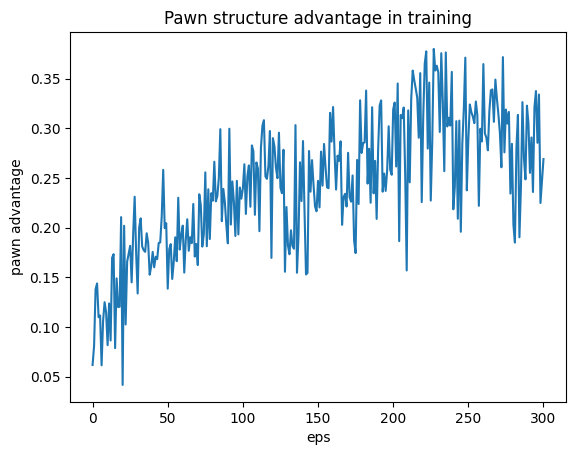

In [62]:
scores = []

plt.clf()
plt.title("Pawn structure advantage in training")
plt.xlabel("eps")
plt.ylabel("pawn advantage")


scores = get_advantage_scores(white_pawn_fens)

plt.plot(epochs, scores)

    

## Center control

In [68]:
white_fens = [
    "rnbqkbnr/1ppppp1p/p5p1/8/3P4/4PN2/PPP2PPP/RNBQKB1R b KQkq - 0 1",
    "rnbqk2r/ppppppbp/5np1/8/2B1P3/2N2N2/PPPP1PPP/R1BQK2R b KQkq - 0 1",
    "rnbqkbnr/pp1p1p2/4p1pp/2p5/2BPP3/2N2N2/PPP2PPP/R1BQK2R b KQkq - 0 1",
    "r1bqkbnr/p2pppp1/1pn4p/2p5/4PB2/2NP1N2/PPP2PPP/R2QKB1R b KQkq - 0 1",
    "rnbqk2r/1ppp1p2/p3pn1p/4P1p1/1bBP1P2/2N2N2/PPP3PP/R1BQK2R b KQkq - 0 1",
    "rn1qkbnr/1pp3pp/p2p1p2/3Pp3/2P1P1b1/2N2N2/PP3PPP/R1BQKB1R b KQkq - 0 1",
    "rnbqk2r/p1p2pbp/1p1p1np1/3Pp3/2B1P3/2N1BN2/PPP2PPP/R2QK2R b KQkq - 0 1",
    "r1bqk1nr/pppp1pp1/7p/2b5/2BpP3/3P1N2/PPPN1PPP/R2QK2R b KQkq - 0 1",
    "rnbqkb1r/p1p1pppp/1p1p1n2/8/3PP3/2N2N2/PPP2PPP/R1BQKB1R b KQkq - 0 1",
    "r1bqkb1r/pppn1pp1/3p1n1p/3Pp3/4P3/2N3P1/PPP2PBP/R1BQK1NR b KQkq - 0 1",
    "r1bqkbnr/pp1n1p2/4p1pp/2ppP3/3P4/1PN2N2/PBP2PPP/R2QKB1R b KQkq - 0 1",
    "rnbqk1nr/ppp1bp2/4p2p/3pP1p1/2PP4/5N2/PP1N1PPP/R1BQKB1R b KQkq c3 0 1",
    "rn1qk1nr/1ppb1pp1/p3p2p/3p4/1b1PPB2/2N2P2/PPP1N1PP/R2QKB1R b KQkq - 0 1",
    "rnbqk2r/1p1pppb1/p4np1/2pP3p/2P1PB2/2N2N2/PP3PPP/R2QKB1R b KQkq - 0 1",
    "r1bqkb1r/pp1npp2/3p1np1/2pP3p/2B1PB2/2N2N2/PPP2PPP/R2QK2R b KQkq - 0 1"
]

to_display = random.choice(white_fens)
board = chess.Board(to_display)
print(board)

r n b q k . . r
. p . p p p b .
p . . . . n p .
. . p P . . . p
. . P . P B . .
. . N . . N . .
P P . . . P P P
R . . Q K B . R


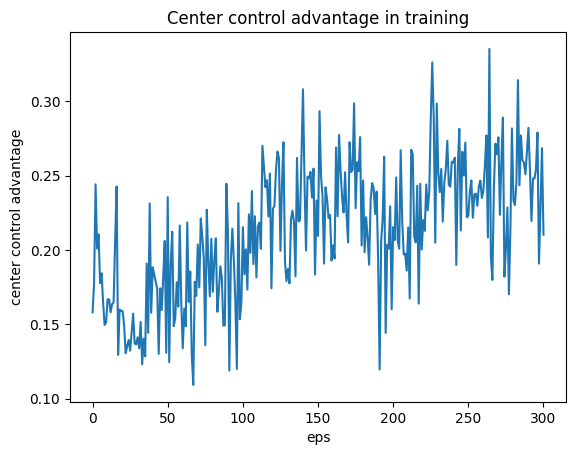

In [63]:

plt.clf()
plt.title("Center control advantage in training")
plt.xlabel("eps")
plt.ylabel("center control advantage")

scores = get_advantage_scores(white_fens)

plt.plot(epochs, scores)

## Development advantage

In [ ]:
fens = [
    "r1bqk1nr/1ppn2bp/p2p1pp1/4p3/2B1P3/2NPBN2/PPP2PPP/R2Q1RK1 b KQkq - 0 1",
    ""
]